Uninstall and install necessary library versions for mediapipe

In [ ]:
# Force compatible versions
!pip uninstall -y numpy mediapipe opencv-python
#!pip install numpy==1.23.5
#!pip install mediapipe==0.10.8 opencv-python


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: opencv-python 4.11.0.86
Uninstalling opencv-python-4.11.0.86:
  Successfully uninstalled opencv-python-4.11.0.86


In [ ]:
!pip install opencv-python mediapipe numpy==1.23.5 pandas matplotlib

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 8.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.5.1
 

In [1]:
import cv2
import mediapipe as mp
import pandas as pd
import matplotlib.pyplot as plt

# Extract and download video from Youtube


In [ ]:
!pip install -q yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.3/173.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 39.1 MB/s eta 0:00:00


In [3]:
import yt_dlp

#Multiperson extraction
url = 'https://www.youtube.com/watch?v=9OiPQBLHVQg'
MultiPersonVideo='MultiPersonVideo.mp4'
output_path = MultiPersonVideo

ydl_opts = {
    'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/mp4',
    'outtmpl': output_path,
    'quiet': True
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([url])


In [ ]:
import yt_dlp

#Single person extraction
url = 'https://www.youtube.com/watch?v=LU5OauL_soU'
SinglePersonVideo='SinglePersonVideo.mp4'
output_path = SinglePersonVideo

ydl_opts = {
    'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/mp4',
    'outtmpl': output_path,
    'quiet': True
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([url])


# Single person pose detection and extraction
We will use the mediapipe library for hand and arm pose extraction from video. This seems the recommended library due to its good performance and light computation.
Library documents:

*   https://ai.google.dev/edge/mediapipe/solutions/vision/hand_landmarker
*   https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker

In [ ]:
# Initialize MediaPipe Pose and Hands
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
pose = mp_pose.Pose(static_image_mode=False)
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2)
mp_drawing = mp.solutions.drawing_utils

In [ ]:
# Desired joints for arms
pose_keys = {
    "LEFT_SHOULDER": mp_pose.PoseLandmark.LEFT_SHOULDER,
    "LEFT_ELBOW": mp_pose.PoseLandmark.LEFT_ELBOW,
    "LEFT_WRIST": mp_pose.PoseLandmark.LEFT_WRIST,
    "RIGHT_SHOULDER": mp_pose.PoseLandmark.RIGHT_SHOULDER,
    "RIGHT_ELBOW": mp_pose.PoseLandmark.RIGHT_ELBOW,
    "RIGHT_WRIST": mp_pose.PoseLandmark.RIGHT_WRIST
}

# Hand joints (21 points)
#hand_keys = [f"HAND_{side}_{i}" for side in ["LEFT", "RIGHT"] for i in range(21)]

In [ ]:
data = []

# Open video
cap = cv2.VideoCapture(SinglePersonVideo)
frame_idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Get pose landmarks
    pose_results = pose.process(frame_rgb)

    # Extract arm coordinates
    frame_data = {"frame": frame_idx}
    if pose_results.pose_landmarks:
        landmarks = pose_results.pose_landmarks.landmark
        for name, idx in pose_keys.items():
            lm = landmarks[idx]
            frame_data[f"{name}_x"] = lm.x
            frame_data[f"{name}_y"] = lm.y
            frame_data[f"{name}_z"] = lm.z
            frame_data[f"{name}_vis"] = lm.visibility

    # Crop region around hands
    #hand_results = hands.process(frame_rgb)

    # Extract hand keypoints
    #if hand_results.multi_hand_landmarks:
    #    for i, hand_landmarks in enumerate(hand_results.multi_hand_landmarks):
    #       side = hand_results.multi_handedness[i].classification[0].label.upper()  # LEFT or RIGHT
    #       for j, lm in enumerate(hand_landmarks.landmark):
    #           frame_data[f"HAND_{side}_{j}_x"] = lm.x
    #           frame_data[f"HAND_{side}_{j}_y"] = lm.y
    #           frame_data[f"HAND_{side}_{j}_z"] = lm.z

    data.append(frame_data)
    frame_idx += 1

cap.release()

# Joints to csv
Extract obtained data to .csv for later analysis.

In [ ]:

# export to CSV
df = pd.DataFrame(data)
df.to_csv("pose_arm_timeseries_Singleperson.csv", index=False)


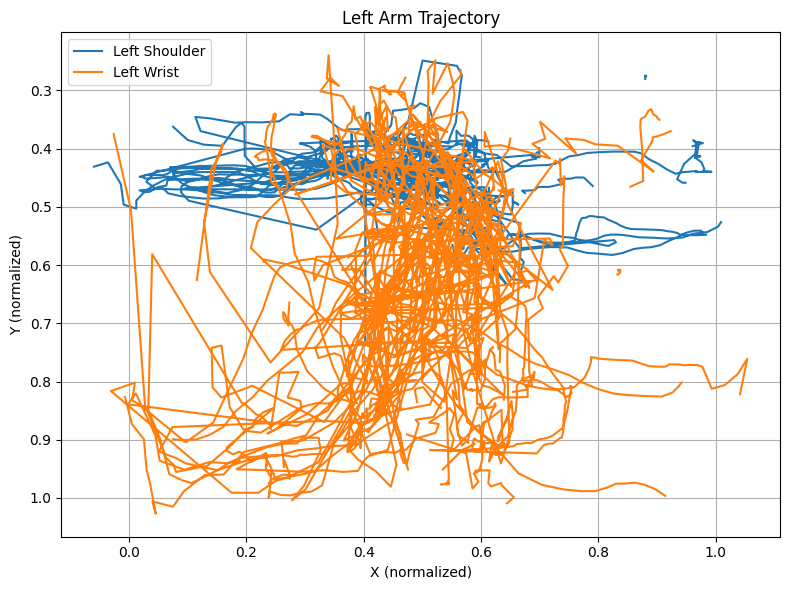

In [ ]:
# Plot shoulder-to-wrist trajectory (left arm)
plt.figure(figsize=(8, 6))
plt.plot(df["LEFT_SHOULDER_x"], df["LEFT_SHOULDER_y"], label="Left Shoulder")
plt.plot(df["LEFT_WRIST_x"], df["LEFT_WRIST_y"], label="Left Wrist")
plt.title("Left Arm Trajectory")
plt.xlabel("X (normalized)")
plt.ylabel("Y (normalized)")
plt.gca().invert_yaxis()  # Flip Y-axis for image coordinate system
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Represent the extraction as live visualization

In [ ]:
import os

# Create folder to save frames with landmarks
os.makedirs("frames", exist_ok=True)

# Open video
cap = cv2.VideoCapture(SinglePersonVideo)
frame_idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Get pose landmarks
    pose_results = pose.process(frame_rgb)

    # Draw pose landmarks
    if pose_results.pose_landmarks:
        mp_drawing.draw_landmarks(
            frame,
            pose_results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2),
        )

    # Save frame with landmarks
    frame_filename = os.path.join("frames", f"frame_{frame_idx:04d}.png")
    cv2.imwrite(frame_filename, frame)

    # Display frame live
    cv2.imshow("Landmark Visualisation", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

    frame_idx += 1

cap.release()
cv2.destroyAllWindows()


OpenCV: Couldn't read video stream from file "SinglePersonVideo.mp4"


# Multi-person pose extraction

Mediapipe does not support multipeople pose extraction. We use MediaPipe Holistic and extract each person's pose separately. YOLO or Openpose would be another option.

In [4]:
import os

# Initialize MediaPipe Holistic module
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# Open video file (replace with your video path or stream)
cap = cv2.VideoCapture(MultiPersonVideo)

# Initialize holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    frame_number = 0
    pose_data = []  # List to store pose data

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Flip the frame horizontally for a more natural selfie-view
        frame = cv2.flip(frame, 1)

        # Convert the BGR image to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process the frame and get the results
        results = holistic.process(rgb_frame)

        # If landmarks are detected, process them
        if results.pose_landmarks:
            # Loop through each detected person (you can extend this part for multiple people if needed)
            # For simplicity, assuming one person per frame
            person_idx = 1

            # Extract body landmarks
            for idx, landmark in enumerate(results.pose_landmarks.landmark):
                landmark_name = f"Body_{idx}"
                x, y, z = landmark.x, landmark.y, landmark.z
                pose_data.append([frame_number, person_idx, landmark_name, x, y, z])

        frame_number += 1

    cap.release()


I0000 00:00:1747146193.799639   21446 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Max
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1747146193.855919   37244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747146193.863303   37251 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747146193.868228   37249 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747146193.868340   37257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747146193.869135   37251 inference_feedback_manager.cc:114] Feedback manager requires a

In [ ]:
# Save to CSV
columns = ["Frame", "Person", "Landmark", "x", "y", "z"]
df = pd.DataFrame(pose_data, columns=columns)
df.to_csv("ballet3.csv", index=False)

# Visualise Exported data

In [ ]:
df.summary

AttributeError: 'DataFrame' object has no attribute 'summary'

# Save CSV in correct format for CycleGAN

Converts XYZ to Radiand and also downsamples 30hz video to 20hz to match robot movement data

Saves as new csv with 7 joint positions as columns to match robot csv file

In [5]:
import pandas as pd
import numpy as np
import os
from scipy import interpolate

def convert_multiperson_data(input_csv, output_dir='joint_data', target_fps=20, source_fps=30, normalize=True):
    print(f"Processing data from {input_csv}")

    os.makedirs(output_dir, exist_ok=True)

    df = pd.read_csv(input_csv)

    persons = df['Person'].unique()

    print(f"Found {len(persons)} person(s) in the data")

    # Define the 7 key joints we want to track (mapped to MediaPipe landmarks)
    joint_mapping = {
        'Position1': 'Body_17',  # finger
        'Position2': 'Body_15',  # wrist
        'Position3': 'Body_13',  # elbow
        'Position4': 'Body_11',  # shoulder
        'Position5': 'Body_23',  # hip
        'Position6': 'Body_25',  # knee
        'Position7': 'Body_27'   # ankle
    }

    # Process each person separately
    for person_id in persons:
        person_df = df[df['Person'] == person_id]

        # Get all frames for this person
        frames = sorted(person_df['Frame'].unique())

        clean_data = {'Frame': frames}

        # Dictionary to store joint positions per frame
        joints_3d = {}
        for joint_name in joint_mapping.keys():
            joints_3d[joint_name] = []

        # Extract each joint 3D position
        for frame in frames:
            frame_joints = {}

            for joint_name in joint_mapping.keys():
                frame_joints[joint_name] = None

            frame_data = person_df[person_df['Frame'] == frame]

            # Extract joint positions
            for joint_name, landmark_name in joint_mapping.items():
                joint_row = frame_data[frame_data['Landmark'] == landmark_name]

                if not joint_row.empty:
                    x, y, z = joint_row['x'].values[0], joint_row['y'].values[0], joint_row['z'].values[0]
                    frame_joints[joint_name] = (x, y, z)

            for joint_name, pos in frame_joints.items():
                joints_3d[joint_name].append(pos)

        # Calculate joint angles
        joint_angles = calculate_joint_angles(joints_3d)

        for joint_name, angles in joint_angles.items():
            clean_data[joint_name] = angles

        clean_df = pd.DataFrame(clean_data)
        clean_df = clean_df.interpolate(method='linear')


        # Normalize joint values to match robot range
        if normalize:
            clean_df = normalize_joint_ranges(clean_df, joint_mapping)

        # Downsample
        downsampled_df = downsample_dataframe(clean_df, source_fps, target_fps)

        output_file = os.path.join(output_dir, f'3Ballet_human_person_{person_id}_joints_{target_fps}hz.csv')
        downsampled_df.to_csv(output_file, index=False)

        print(f"Saved data for person {person_id} to {output_file}")

In [6]:
def calculate_joint_angles(joints_3d):
    joint_angles = {}

    for joint_name in joints_3d.keys():
        joint_angles[joint_name] = []

    n_frames = len(joints_3d['Position1'])

    for frame in range(n_frames):
        pos1 = joints_3d['Position1'][frame]  # finger
        pos2 = joints_3d['Position2'][frame]  # wrist
        pos3 = joints_3d['Position3'][frame]  # elbow
        pos4 = joints_3d['Position4'][frame]  # shoulder
        pos5 = joints_3d['Position5'][frame]  # hip
        pos6 = joints_3d['Position6'][frame]  # knee
        pos7 = joints_3d['Position7'][frame]  # ankle

        if None in [pos1, pos2, pos3, pos4, pos5, pos6, pos7]:
            for joint_name in joint_angles.keys():
                joint_angles[joint_name].append(np.nan)
            continue

        # Calculate angles
        # Position1: Finger angle (relative to wrist)
        finger_vec = np.array(pos1) - np.array(pos2)
        wrist_vec = np.array(pos2) - np.array(pos3)
        angle1 = angle_between_vectors(finger_vec, wrist_vec)

        # Position2: Wrist angle (relative to elbow)
        wrist_vec = np.array(pos2) - np.array(pos3)
        elbow_vec = np.array(pos3) - np.array(pos4)
        angle2 = angle_between_vectors(wrist_vec, elbow_vec)

        # Position3: Elbow angle (relative to shoulder)
        elbow_vec = np.array(pos3) - np.array(pos4)
        shoulder_vec = np.array(pos4) - np.array(pos5)
        angle3 = angle_between_vectors(elbow_vec, shoulder_vec)

        # Position4: Shoulder angle (3D orientation)
        vertical = np.array([0, 1, 0])  # Assuming Y is vertical
        angle4 = angle_between_vectors(shoulder_vec, vertical)

        # Position5: Hip angle
        hip_vec = np.array(pos5) - np.array(pos6)
        angle5 = angle_between_vectors(hip_vec, vertical)

        # Position6: Knee angle
        knee_vec = np.array(pos6) - np.array(pos7)
        angle6 = angle_between_vectors(knee_vec, hip_vec)

        # Position7: Ankle angle (orientation)
        ground_normal = np.array([0, 0, 1])  # Assuming Z is up from ground
        angle7 = angle_between_vectors(knee_vec, ground_normal)

        # Add to joint angles
        joint_angles['Position1'].append(angle1)
        joint_angles['Position2'].append(angle2)
        joint_angles['Position3'].append(angle3)
        joint_angles['Position4'].append(angle4)
        joint_angles['Position5'].append(angle5)
        joint_angles['Position6'].append(angle6)
        joint_angles['Position7'].append(angle7)

    return joint_angles

In [7]:
def angle_between_vectors(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)

    v1_norm = np.linalg.norm(v1)
    v2_norm = np.linalg.norm(v2)

    if v1_norm < 1e-10 or v2_norm < 1e-10:
        return 0.0

    v1 = v1 / v1_norm
    v2 = v2 / v2_norm

    dot_product = np.clip(np.dot(v1, v2), -1.0, 1.0)
    angle = np.arccos(dot_product)

    return angle

In [8]:
def normalize_joint_ranges(df, joint_mapping):
    # Robot joint ranges (in radians)
    robot_ranges = {
        'Position1': (-2.9, 2.9),    # Joint 1
        'Position2': (-1.8, 1.8),    # Joint 2
        'Position3': (-2.9, 2.9),    # Joint 3
        'Position4': (-3.1, 0.0),    # Joint 4
        'Position5': (-2.9, 2.9),    # Joint 5
        'Position6': (-0.0, 3.8),    # Joint 6
        'Position7': (-2.9, 2.9)     # Joint 7
    }

    normalized_df = df.copy()

    # Normalize each joint
    for joint_name in joint_mapping.keys():
        current_min = np.nanmin(df[joint_name])
        current_max = np.nanmax(df[joint_name])

        if np.abs(current_max - current_min) < 1e-6:
            continue

        target_min, target_max = robot_ranges[joint_name]
        normalized_df[joint_name] = (df[joint_name] - current_min) / (current_max - current_min) * (target_max - target_min) + target_min

    return normalized_df

In [9]:
def downsample_dataframe(df, source_fps, target_fps):
    downsample_factor = source_fps / target_fps

    if downsample_factor == 1:
        return df

    original_frames = df['Frame'].values
    n_frames_new = int(len(original_frames) / downsample_factor)
    data_cols = [col for col in df.columns if col != 'Frame']
    downsampled_data = {'Frame': np.arange(n_frames_new)}

    original_time = np.arange(len(df)) / source_fps
    new_time = np.arange(n_frames_new) / target_fps

    for col in data_cols:
        interpolated = interpolate.interp1d(
            original_time,
            df[col].values,
            kind='linear',
            bounds_error=False,
            fill_value='extrapolate'
        )

        downsampled_data[col] = interpolated(new_time)

    downsampled_df = pd.DataFrame(downsampled_data)

    return downsampled_df

In [10]:
convert_multiperson_data(
    input_csv='ballet3.csv',
    output_dir='joint_data',
    target_fps=20,
    source_fps=30,
    normalize=True
)

Processing data from ballet3.csv
Found 1 person(s) in the data
Saved data for person 1 to joint_data/3Ballet_human_person_1_joints_20hz.csv


Testing overlay of joints on video

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter

def create_joint_overlay_video(input_video_path, output_video_path, csv_path=None, show_skeleton=True, fps=30):
    """
    Create a video with joint extraction overlay

    Args:
        input_video_path: Path to the input video file
        output_video_path: Path to save the output video
        csv_path: Optional path to pre-extracted joint data CSV
        show_skeleton: Whether to show skeletal connections
        fps: Frames per second of the input video
    """
    # Initialize MediaPipe
    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)

    # Define the joints we're interested in
    joint_mapping = {
        'Position1': mp_pose.PoseLandmark.LEFT_INDEX,  # finger
        'Position2': mp_pose.PoseLandmark.LEFT_WRIST,  # wrist
        'Position3': mp_pose.PoseLandmark.LEFT_ELBOW,  # elbow
        'Position4': mp_pose.PoseLandmark.LEFT_SHOULDER,  # shoulder
        'Position5': mp_pose.PoseLandmark.LEFT_HIP,  # hip
        'Position6': mp_pose.PoseLandmark.LEFT_KNEE,  # knee
        'Position7': mp_pose.PoseLandmark.LEFT_ANKLE  # ankle
    }

    # Color mapping for visualization
    color_mapping = {
        'Position1': (255, 0, 0),    # Blue
        'Position2': (0, 255, 0),    # Green
        'Position3': (0, 0, 255),    # Red
        'Position4': (255, 255, 0),  # Cyan
        'Position5': (255, 0, 255),  # Magenta
        'Position6': (0, 255, 255),  # Yellow
        'Position7': (255, 255, 255) # White
    }

    # Open video
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {input_video_path}")
        return

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Create VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Load pre-extracted data if provided
    extracted_data = None
    if csv_path and os.path.exists(csv_path):
        extracted_data = pd.read_csv(csv_path)
        print(f"Loaded pre-extracted data from {csv_path}")

    # Process each frame
    frame_idx = 0
    extracted_positions = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Create a copy for visualization
        vis_frame = frame.copy()

        # Draw frame number
        cv2.putText(vis_frame, f"Frame: {frame_idx}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # If we have pre-extracted data, use it
        if extracted_data is not None and frame_idx < len(extracted_data):
            frame_data = extracted_data.iloc[frame_idx]

            # Draw extracted joints
            for joint_name, color in color_mapping.items():
                if joint_name in frame_data:
                    # For data from our custom format
                    x, y = int(frame_data[f"{joint_name}_x"] * width), int(frame_data[f"{joint_name}_y"] * height)
                    cv2.circle(vis_frame, (x, y), 10, color, -1)
                    cv2.putText(vis_frame, joint_name, (x+10, y),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

                    # Store positions for later verification
                    extracted_positions.append({
                        'frame': frame_idx,
                        'joint': joint_name,
                        'x': x / width,
                        'y': y / height
                    })
        else:
            # Process frame with MediaPipe
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(frame_rgb)

            if results.pose_landmarks:
                # Draw the full skeleton if requested
                if show_skeleton:
                    mp_drawing.draw_landmarks(
                        vis_frame,
                        results.pose_landmarks,
                        mp_pose.POSE_CONNECTIONS,
                        landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                        connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2)
                    )

                # Extract and visualize our specific joints of interest
                landmarks = results.pose_landmarks.landmark

                # Store positions for current frame
                frame_positions = {'frame': frame_idx}

                for joint_name, landmark_idx in joint_mapping.items():
                    lm = landmarks[landmark_idx]
                    x, y = int(lm.x * width), int(lm.y * height)

                    # Draw a colored circle at joint position
                    cv2.circle(vis_frame, (x, y), 10, color_mapping[joint_name], -1)

                    # Add label
                    cv2.putText(vis_frame, joint_name, (x+10, y),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_mapping[joint_name], 2)

                    # Store normalized positions
                    frame_positions[f"{joint_name}_x"] = lm.x
                    frame_positions[f"{joint_name}_y"] = lm.y
                    frame_positions[f"{joint_name}_z"] = lm.z

                # Add to extracted positions
                extracted_positions.append(frame_positions)

        # Write frame to output video
        out.write(vis_frame)

        # Display progress
        if frame_idx % 100 == 0:
            print(f"Processed frame {frame_idx}")

        frame_idx += 1

    # Release resources
    cap.release()
    out.release()

    print(f"Video processing complete. Output saved to {output_video_path}")
    print(f"Processed {frame_idx} frames")

    # If we didn't use pre-extracted data, save the extracted positions
    if extracted_data is None and extracted_positions:
        extracted_df = pd.DataFrame(extracted_positions)
        csv_output = os.path.splitext(output_video_path)[0] + "_joints.csv"
        extracted_df.to_csv(csv_output, index=False)
        print(f"Saved extracted joint positions to {csv_output}")

    return extracted_positions

def create_joint_overlay_video_from_csv(video_path, csv_path, output_path, fps=30):
    """
    Create a visualization overlaying extracted joints from CSV onto the original video

    Args:
        video_path: Path to the input video
        csv_path: Path to the CSV with joint data
        output_path: Path to save the output video
        fps: Frames per second of the input video
    """
    # Load the CSV data
    if csv_path.endswith('.csv'):
        # Standard CSV format (one row per frame)
        df = pd.read_csv(csv_path)

        # Check if this is MultiPerson data format
        if 'Person' in df.columns and 'Landmark' in df.columns:
            # Convert from multi-person format to frame-joint format
            print("Detected multi-person data format. Converting...")
            df = convert_multiperson_to_frame_format(df)
    else:
        print(f"Unsupported file format: {csv_path}")
        return

    # Call the main function with pre-extracted data
    return create_joint_overlay_video(video_path, output_path, csv_path=csv_path, fps=fps)

def convert_multiperson_to_frame_format(df):
    """
    Convert multi-person data format to frame-joint format

    Args:
        df: DataFrame in multi-person format (Frame, Person, Landmark, x, y, z)

    Returns:
        DataFrame in frame-joint format (frame, Position1_x, Position1_y, ...)
    """
    # Define mapping from Body_X to Position labels
    landmark_to_position = {
        'Body_17': 'Position1',  # finger
        'Body_15': 'Position2',  # wrist
        'Body_13': 'Position3',  # elbow
        'Body_11': 'Position4',  # shoulder
        'Body_23': 'Position5',  # hip
        'Body_25': 'Position6',  # knee
        'Body_27': 'Position7'   # ankle
    }

    # Initialize new dataframe
    frames = df['Frame'].unique()
    persons = df['Person'].unique()
    print(f"Frames: {frames}, Persons: {persons}")

    # We'll process each person separately
    result_dfs = []

    for person_id in persons:
        person_df = df[df['Person'] == person_id]

        # Initialize new dataframe for this person
        new_data = {'frame': frames}

        for landmark_name, position_name in landmark_to_position.items():
            landmark_data = person_df[person_df['Landmark'] == landmark_name]

            # Initialize with NaN
            new_data[f"{position_name}_x"] = np.nan
            new_data[f"{position_name}_y"] = np.nan
            new_data[f"{position_name}_z"] = np.nan

            # Fill in data where available
            for _, row in landmark_data.iterrows():
                frame_idx = row['Frame']
                frame_pos = np.where(frames == frame_idx)[0][0]

                new_data[f"{position_name}_x"][frame_pos] = row['x']
                new_data[f"{position_name}_y"][frame_pos] = row['y']
                new_data[f"{position_name}_z"][frame_pos] = row['z']

        # Create dataframe and fill missing values
        result_df = pd.DataFrame(new_data)
        result_df = result_df.interpolate(method='linear')
        result_dfs.append(result_df)

    # Combine all person dataframes
    # For simplicity, we'll just use the first person if there are multiple
    return result_dfs[0]

def verify_extracted_joints(csv_path, show_plot=True):
    """
    Verify the extracted joints by plotting their trajectories

    Args:
        csv_path: Path to the CSV with joint data
        show_plot: Whether to display the plot
    """
    # Load the CSV data
    if csv_path.endswith('.csv'):
        # Standard CSV format (one row per frame)
        df = pd.read_csv(csv_path)

        # Check if this is MultiPerson data format
        if 'Person' in df.columns and 'Landmark' in df.columns:
            print("Detected multi-person data format. Converting...")
            df = convert_multiperson_to_frame_format(df)
    else:
        print(f"Unsupported file format: {csv_path}")
        return

    # Plot joint trajectories
    plt.figure(figsize=(15, 10))

    # Find position columns
    position_cols = [col for col in df.columns if col.startswith('Position')]

    # Group by joint number
    joint_numbers = set()
    for col in position_cols:
        if '_x' in col or '_y' in col:
            joint_num = col.split('_')[0][-1]  # Extract the number from 'Position1_x'
            joint_numbers.add(joint_num)

    # Create subplots for each joint
    for i, joint_num in enumerate(sorted(joint_numbers)):
        plt.subplot(len(joint_numbers), 1, i+1)

        x_col = f"Position{joint_num}_x"
        y_col = f"Position{joint_num}_y"

        if x_col in df.columns and y_col in df.columns:
            plt.plot(df[x_col], label=f'Joint {joint_num} X')
            plt.plot(df[y_col], label=f'Joint {joint_num} Y')
            plt.title(f'Joint {joint_num} Trajectory')
            plt.xlabel('Frame')
            plt.ylabel('Position (normalized)')
            plt.legend()
            plt.grid(True)

    plt.tight_layout()

    # Save plot
    plot_path = os.path.splitext(csv_path)[0] + "_trajectory.png"
    plt.savefig(plot_path)
    print(f"Saved trajectory plot to {plot_path}")

    if show_plot:
        plt.show()

def create_animated_visualization(csv_path, output_path, fps=30):
    """
    Create an animated visualization of joint movements over time

    Args:
        csv_path: Path to the CSV with joint data
        output_path: Path to save the animation
        fps: Frames per second for the animation
    """
    # Load the CSV data
    if csv_path.endswith('.csv'):
        # Standard CSV format (one row per frame)
        df = pd.read_csv(csv_path)

        # Check if this is MultiPerson data format
        if 'Person' in df.columns and 'Landmark' in df.columns:
            print("Detected multi-person data format. Converting...")
            df = convert_multiperson_to_frame_format(df)
    else:
        print(f"Unsupported file format: {csv_path}")
        return

    # Set up figure and axes
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.invert_yaxis()  # Invert Y-axis for image coordinate system
    ax.set_aspect('equal')
    ax.grid(True)

    # Find position columns
    x_cols = [col for col in df.columns if col.endswith('_x')]
    y_cols = [col for col in df.columns if col.endswith('_y')]

    # Sort by joint number
    joint_numbers = []
    for col in x_cols:
        joint_num = col.split('_')[0][-1]  # Extract the number from 'Position1_x'
        joint_numbers.append(int(joint_num))

    joint_numbers = sorted(joint_numbers)

    # Color mapping
    colors = plt.cm.rainbow(np.linspace(0, 1, len(joint_numbers)))

    # Connections between joints
    connections = [
        (1, 2),  # finger to wrist
        (2, 3),  # wrist to elbow
        (3, 4),  # elbow to shoulder
        (4, 5),  # shoulder to hip
        (5, 6),  # hip to knee
        (6, 7)   # knee to ankle
    ]

    # Initialize scatter plots
    scatters = []
    for i, joint_num in enumerate(joint_numbers):
        x_col = f"Position{joint_num}_x"
        y_col = f"Position{joint_num}_y"

        if x_col in df.columns and y_col in df.columns:
            scatter = ax.scatter([], [], s=100, color=colors[i], label=f'Joint {joint_num}')
            scatters.append((joint_num, scatter))

    # Initialize lines for connections
    lines = []
    for start, end in connections:
        line, = ax.plot([], [], 'k-', lw=2, alpha=0.5)
        lines.append((start, end, line))

    # Add time indicator
    time_text = ax.text(0.02, 0.02, '', transform=ax.transAxes)

    # Animation update function
    def update(frame):
        for joint_num, scatter in scatters:
            x_col = f"Position{joint_num}_x"
            y_col = f"Position{joint_num}_y"

            if frame < len(df) and x_col in df.columns and y_col in df.columns:
                x = df.loc[frame, x_col]
                y = df.loc[frame, y_col]

                scatter.set_offsets(np.array([[x, y]]))

        # Update connections
        for start, end, line in lines:
            start_x_col = f"Position{start}_x"
            start_y_col = f"Position{start}_y"
            end_x_col = f"Position{end}_x"
            end_y_col = f"Position{end}_y"

            if frame < len(df) and all(col in df.columns for col in [start_x_col, start_y_col, end_x_col, end_y_col]):
                start_x = df.loc[frame, start_x_col]
                start_y = df.loc[frame, start_y_col]
                end_x = df.loc[frame, end_x_col]
                end_y = df.loc[frame, end_y_col]

                line.set_data([start_x, end_x], [start_y, end_y])

        # Update time
        time_text.set_text(f'Frame: {frame}')

        return scatters + lines + [time_text]

    # Create animation
    anim = FuncAnimation(fig, update, frames=len(df), interval=1000/fps, blit=False)

    # Add title and legend
    plt.title('Joint Movement Visualization')
    plt.legend(loc='upper right')

    # Save animation
    writer = FFMpegWriter(fps=fps)
    anim.save(output_path, writer=writer)
    print(f"Saved animation to {output_path}")

    plt.close()

if __name__ == "__main__":
    # Choose which visualization to create

    # Option 1: Process video and overlay joints
    video_path = "MultiPersonVideo.mp4"
    output_path = "joint_overlay.mp4"
    create_joint_overlay_video(video_path, output_path)

    # Option 2: Use pre-extracted CSV data to create overlay
    #csv_path = "MultipeopleData2.csv"
    #output_path = "joint_overlay_from_csv.mp4"
    #create_joint_overlay_video_from_csv(video_path, csv_path, output_path)

    # Option 3: Verify extracted joints with trajectory plots
    #csv_path = "MultipeopleData2.csv"
    #verify_extracted_joints(csv_path)

    # Option 4: Create animated visualization of joints
    #csv_path = "MultipeopleData2.csv"
    #animation_path = "joint_animation.mp4"
    #create_animated_visualization(csv_path, animation_path)

I0000 00:00:1746625724.101303 24286599 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Max
W0000 00:00:1746625724.142431 24290439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746625724.150278 24290439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed frame 0
Processed frame 100
Processed frame 200
Processed frame 300
Processed frame 400
Processed frame 500
Processed frame 600
Processed frame 700
Processed frame 800
Processed frame 900
Processed frame 1000
Processed frame 1100
Processed frame 1200
Processed frame 1300
Processed frame 1400
Processed frame 1500
Processed frame 1600
Processed frame 1700
Processed frame 1800
Processed frame 1900
Processed frame 2000
Processed frame 2100
Processed frame 2200
Processed frame 2300
Processed frame 2400
Processed frame 2500
Processed frame 2600
Processed frame 2700
Processed frame 2800
Video processing complete. Output saved to joint_overlay.mp4
Processed 2832 frames
Saved extracted joint positions to joint_overlay_joints.csv
